In [1]:
import dataAcquisition as da

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [4]:
df=da.getStablePoolHistory(10000000)

In [5]:
df

,date,tvlUSD,volumeUSD,feesUSD,pool_id,pool_name
0,2021-05-24,4.038929e+05,1.560326e+05,78.016302,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
1,2021-05-25,6.273335e+05,1.641681e+06,820.840475,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
2,2021-05-26,6.411043e+05,1.581438e+05,79.071880,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
3,2021-05-27,6.411378e+05,6.312746e+04,31.563732,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
4,2021-05-28,5.229501e+05,3.004094e+05,150.204708,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
...,...,...,...,...,...,...
2263,2022-10-19,2.439499e+07,3.028606e+06,1514.302855,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC_USDT_05
2264,2022-10-20,2.440134e+07,3.284843e+06,1642.421502,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC_USDT_05
2265,2022-10-21,2.467383e+07,2.299657e+06,1149.828502,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC_USDT_05
2266,2022-10-22,2.493749e+07,8.260988e+05,413.049380,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,USDC_USDT_05


In [6]:
df.groupby('pool_name').size()

pool_name
BUSD_USDC_05    503
DAI_USDC_01     345
DAI_USDC_05     537
USDC_USDT_01    345
USDC_USDT_05    538
dtype: int64

In [7]:
volume_df=df.groupby('date').volumeUSD.sum().to_frame().reset_index()

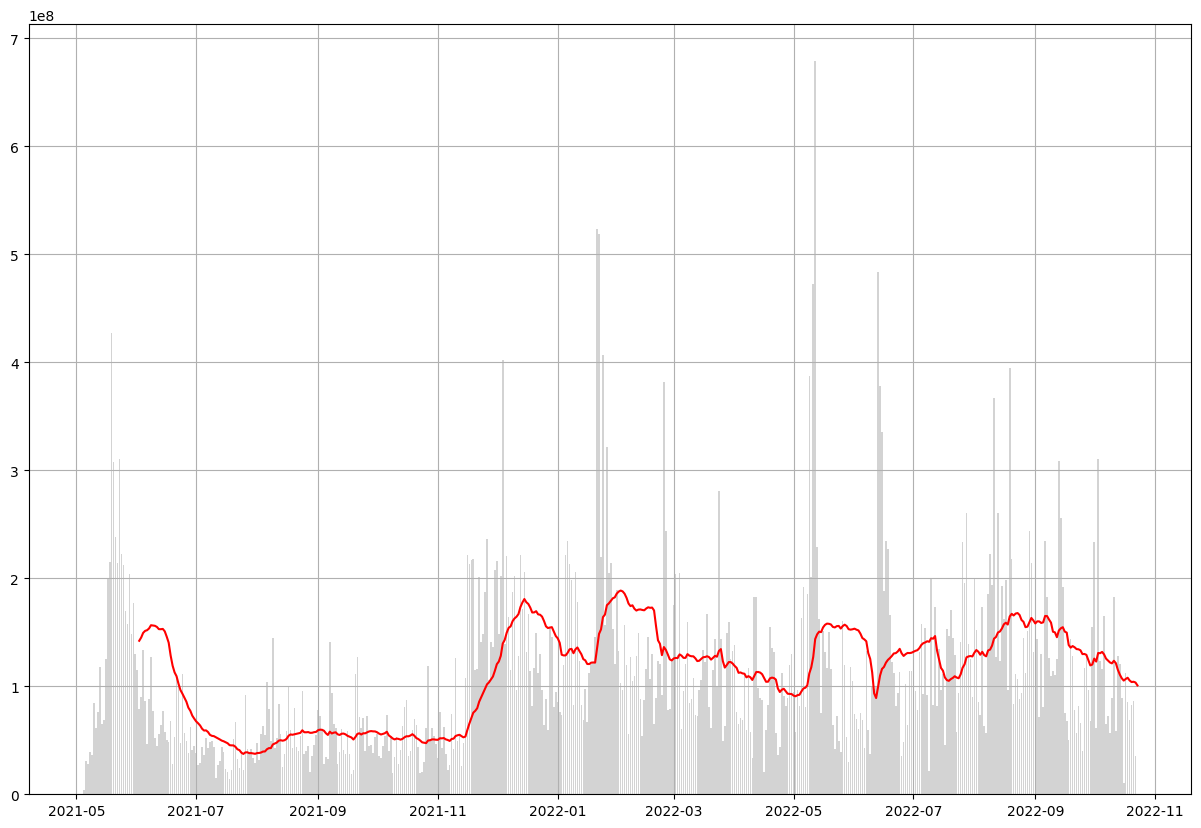

In [8]:
plt.bar(volume_df.date,volume_df.volumeUSD,color='lightgrey')
plt.plot(volume_df.date,volume_df.volumeUSD.rolling(30).mean(),color='red')
_=plt.grid()

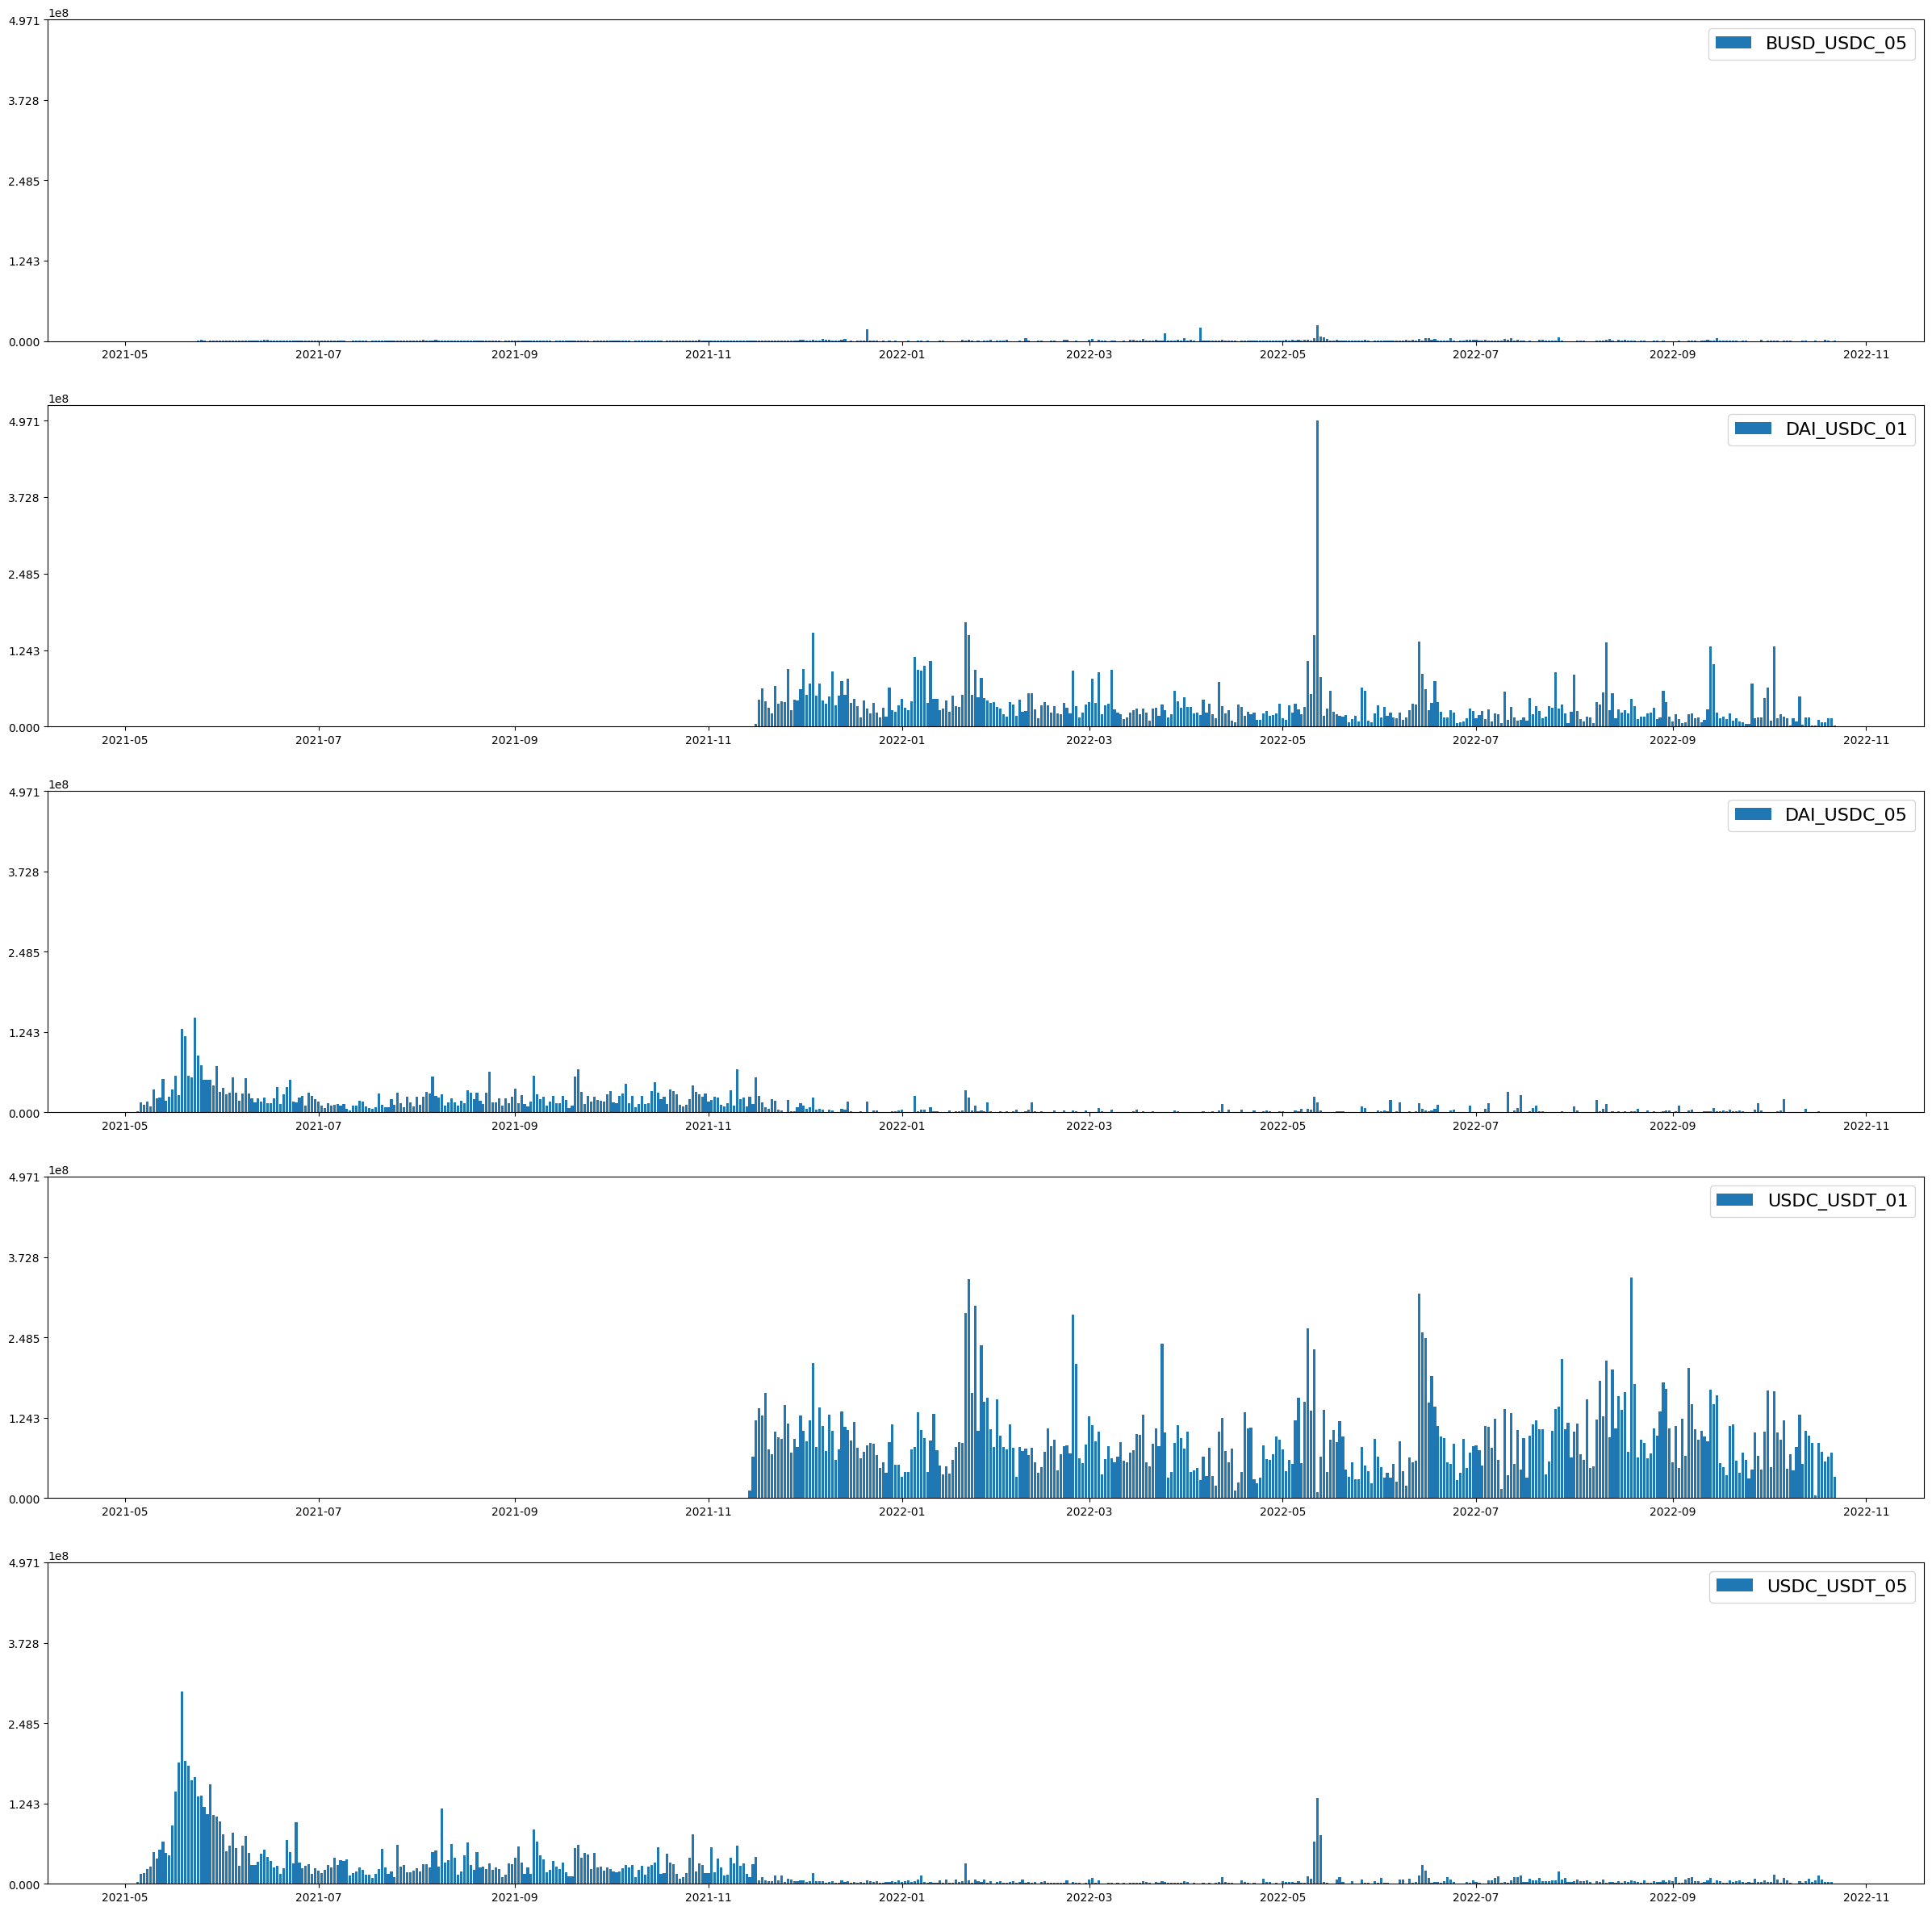

In [9]:
fig,plots=plt.subplots(5,figsize=(30,30))

date_range=pd.date_range(df.date.min(),df.date.max())
dr_df=pd.DataFrame(date_range)
dr_df.columns=['date']

plot_y=np.linspace(0,df.volumeUSD.max(),5)

for i,(pool_name,frame) in enumerate(df.groupby('pool_name')):
    merged=dr_df.merge(frame[['date','volumeUSD']],on='date',how='outer')
    merged['volumeUSD']=np.where(merged.volumeUSD.isna(),0,merged.volumeUSD)
    plots[i].bar(merged.date,merged.volumeUSD,label=pool_name)
    plots[i].legend(fontsize=16)
    plots[i].set_yticks(plot_y)

In [10]:
start_date=df[df.pool_name=='USDC_USDT_01'].date.min()
start_date

Timestamp('2021-11-13 00:00:00')

In [11]:
df['returns']=df.feesUSD/df.tvlUSD

In [12]:
current_env=df[df.date>=start_date].copy()

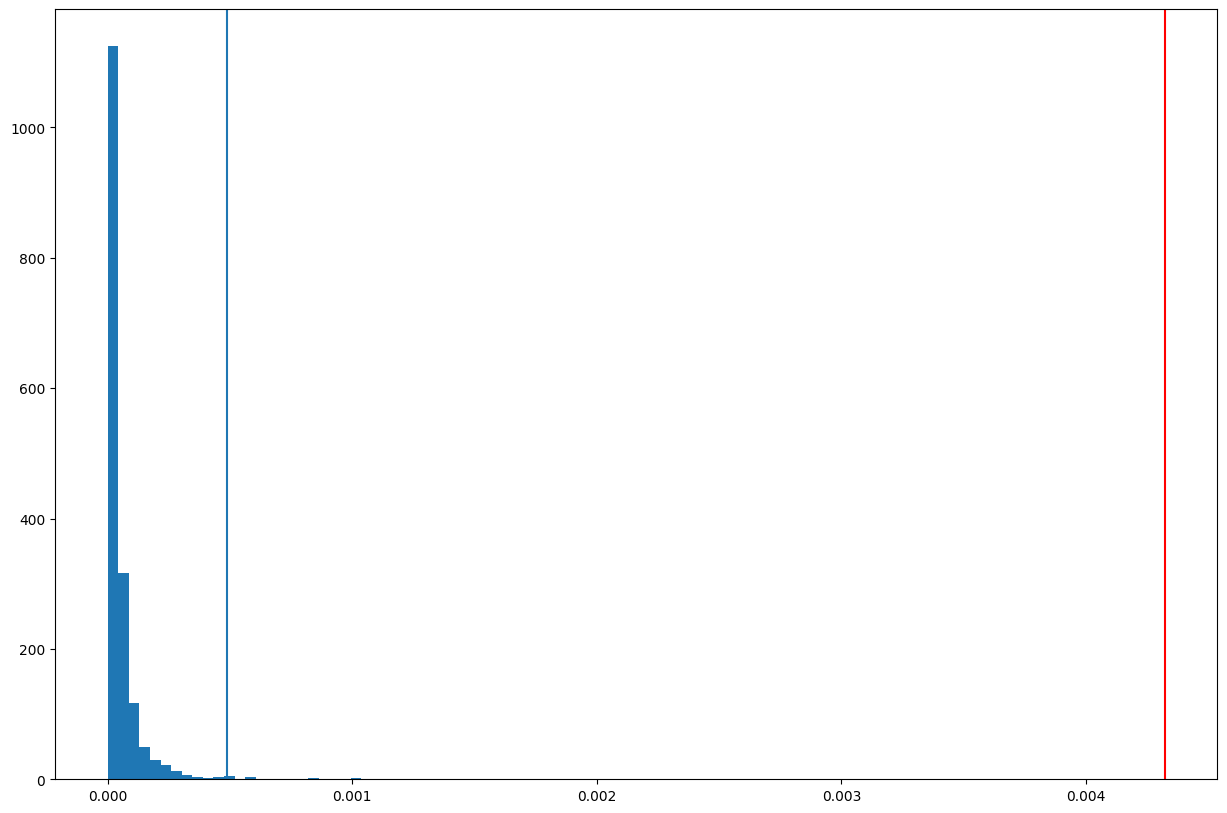

In [13]:
cutoff_percentage=.99
cutoff_return=current_env.sort_values('returns',ascending=True).iloc[int(cutoff_percentage*len(current_env))].returns
plt.axvline(cutoff_return)
plt.axvline(current_env.returns.max(),color='red')
_=plt.hist(current_env.returns,bins=100)

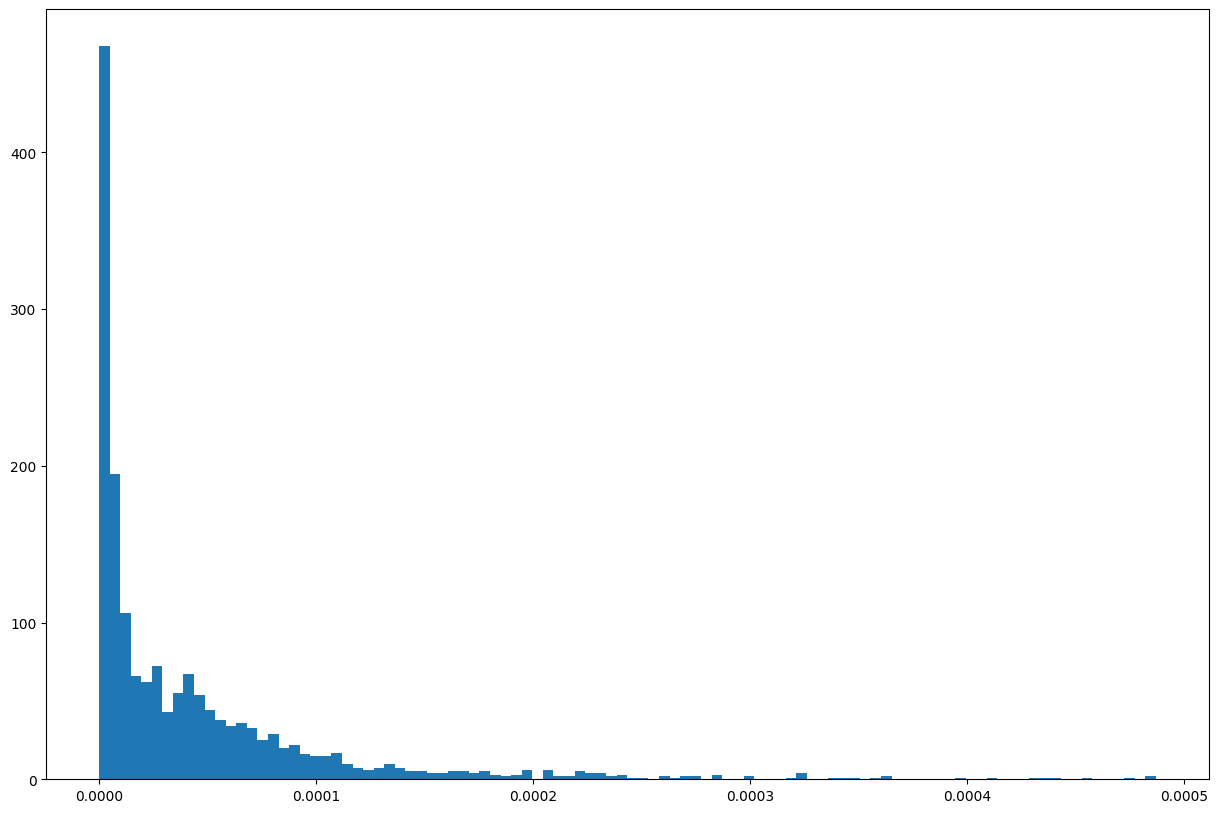

In [14]:
_=plt.hist(current_env[current_env.returns<=cutoff_return].returns,bins=100)

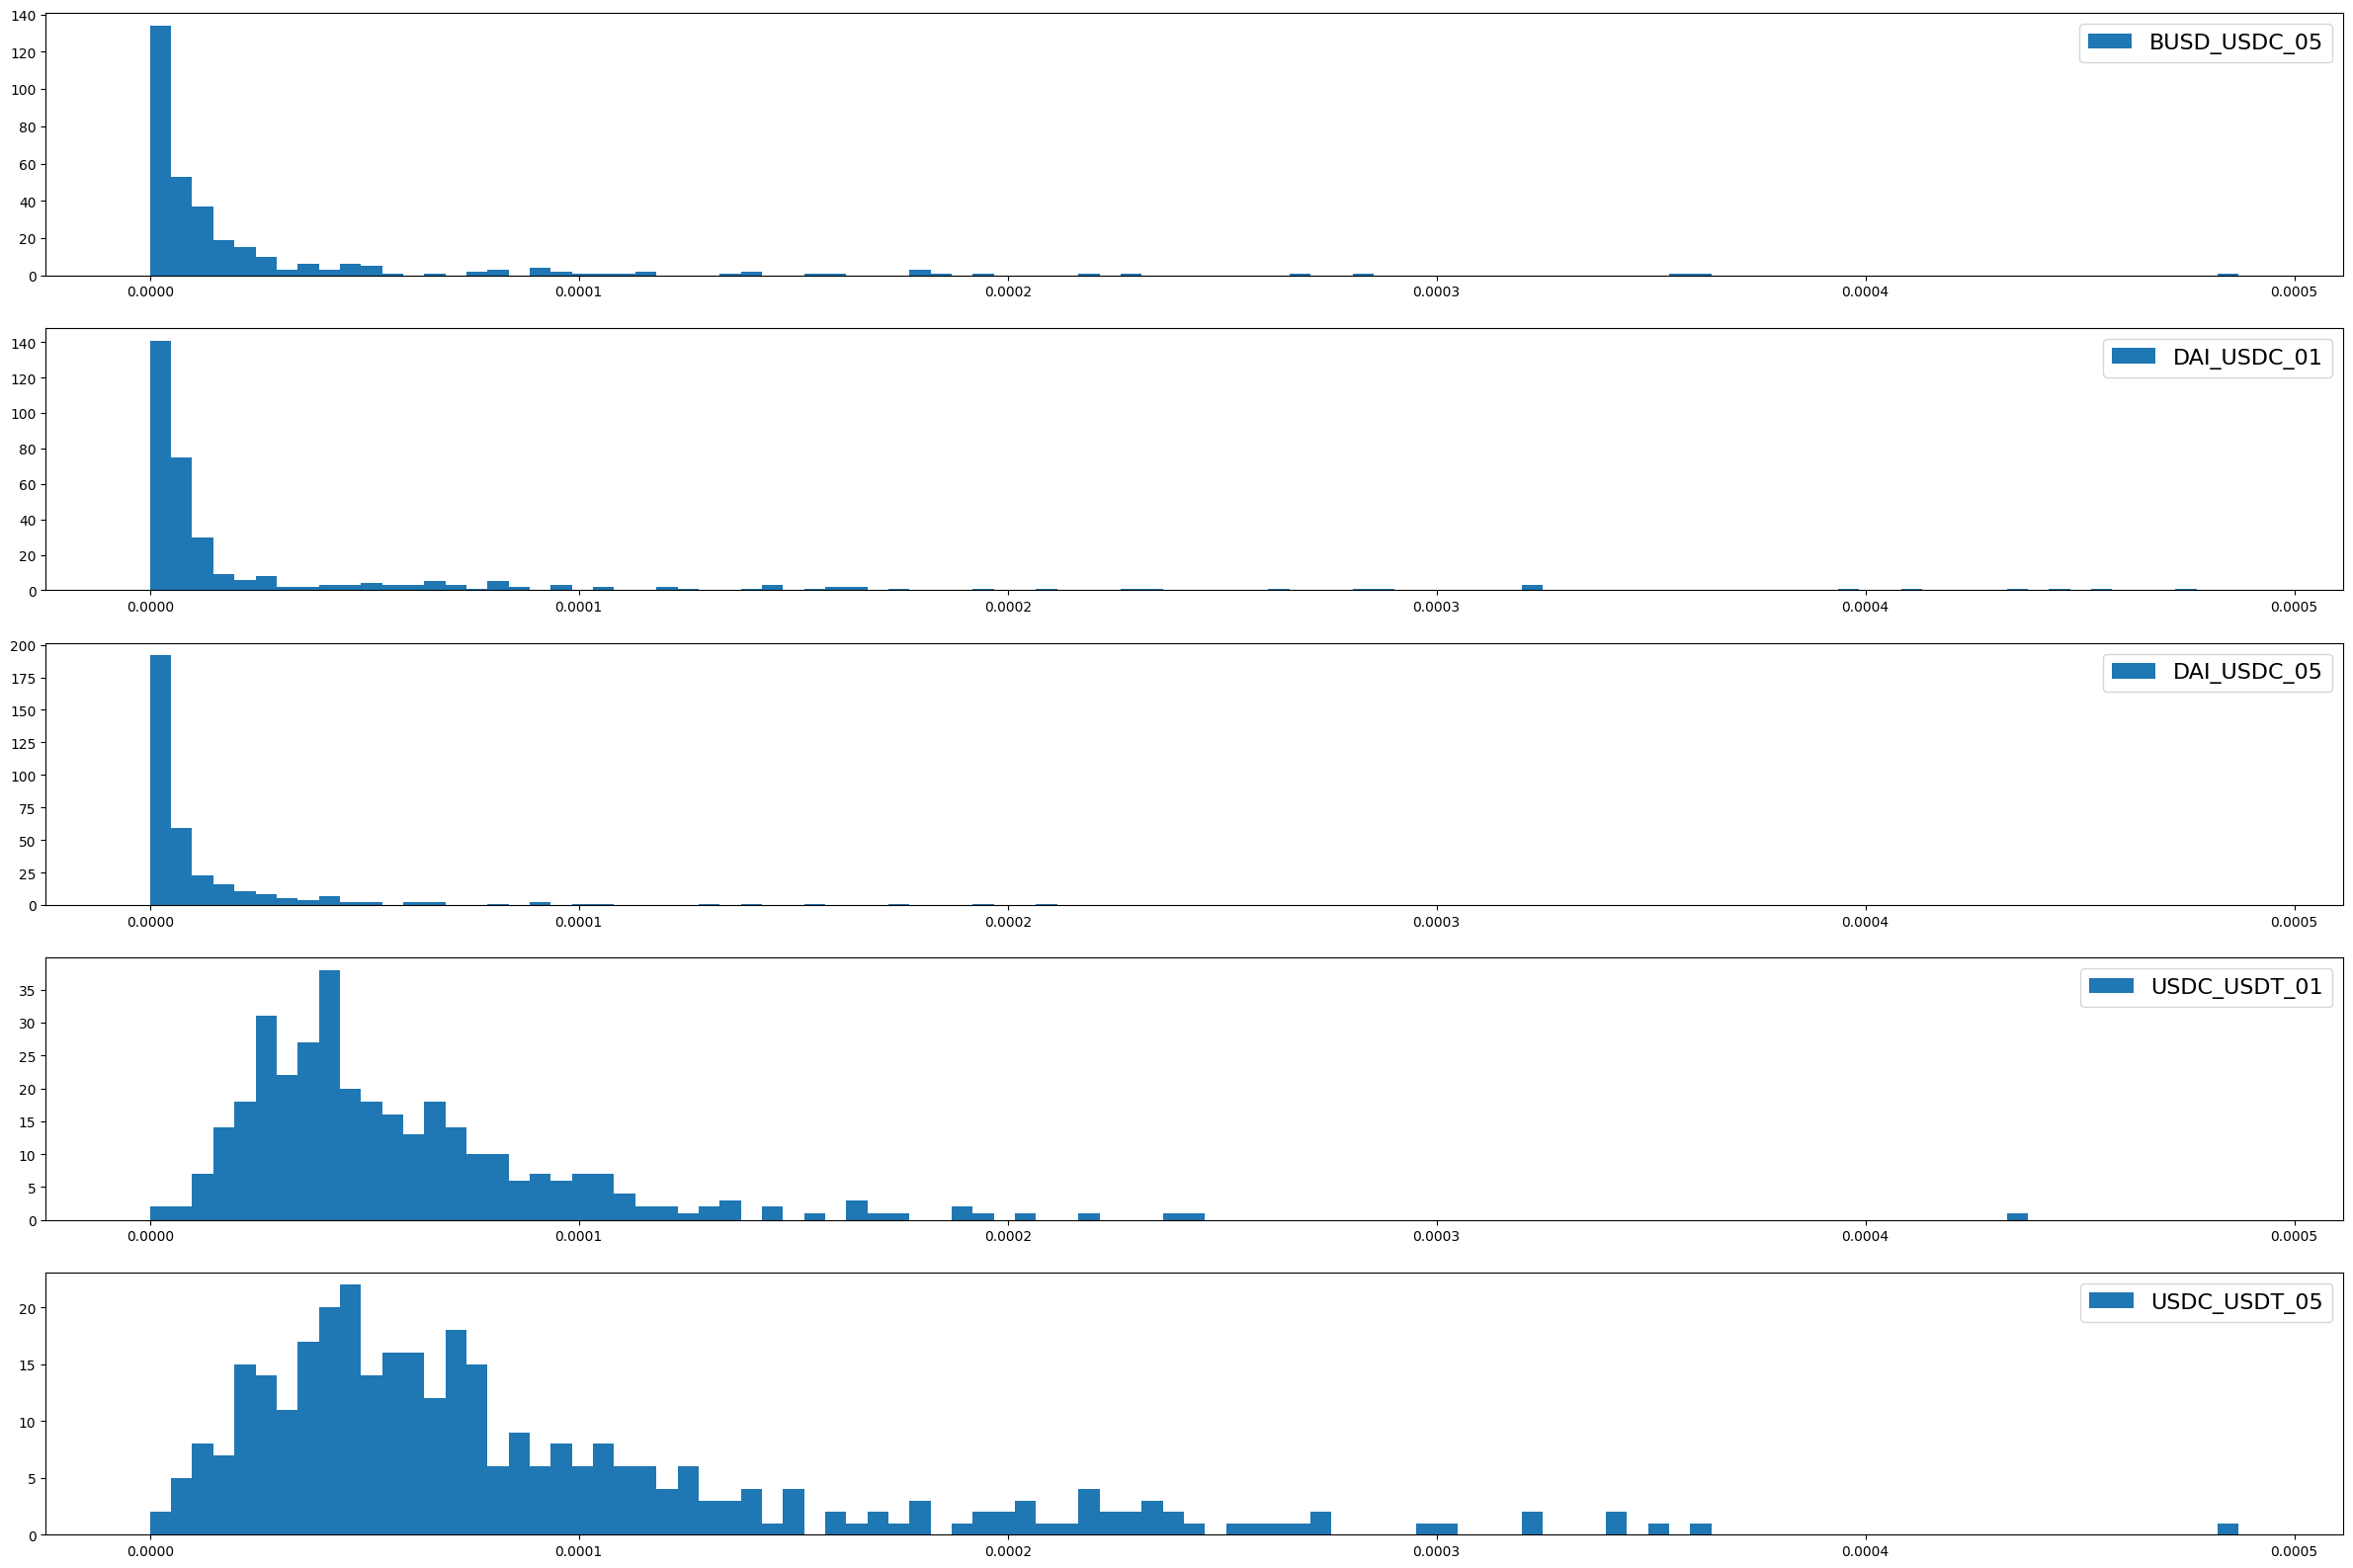

In [15]:
fig,plots=plt.subplots(5,figsize=(30,20))

for i,(pool_name,frame) in enumerate(current_env.groupby('pool_name')):
    plots[i].hist(frame[frame.returns<=cutoff_return].returns,bins=np.linspace(0,cutoff_return,num=100),label=pool_name)
    plots[i].legend(fontsize=16)

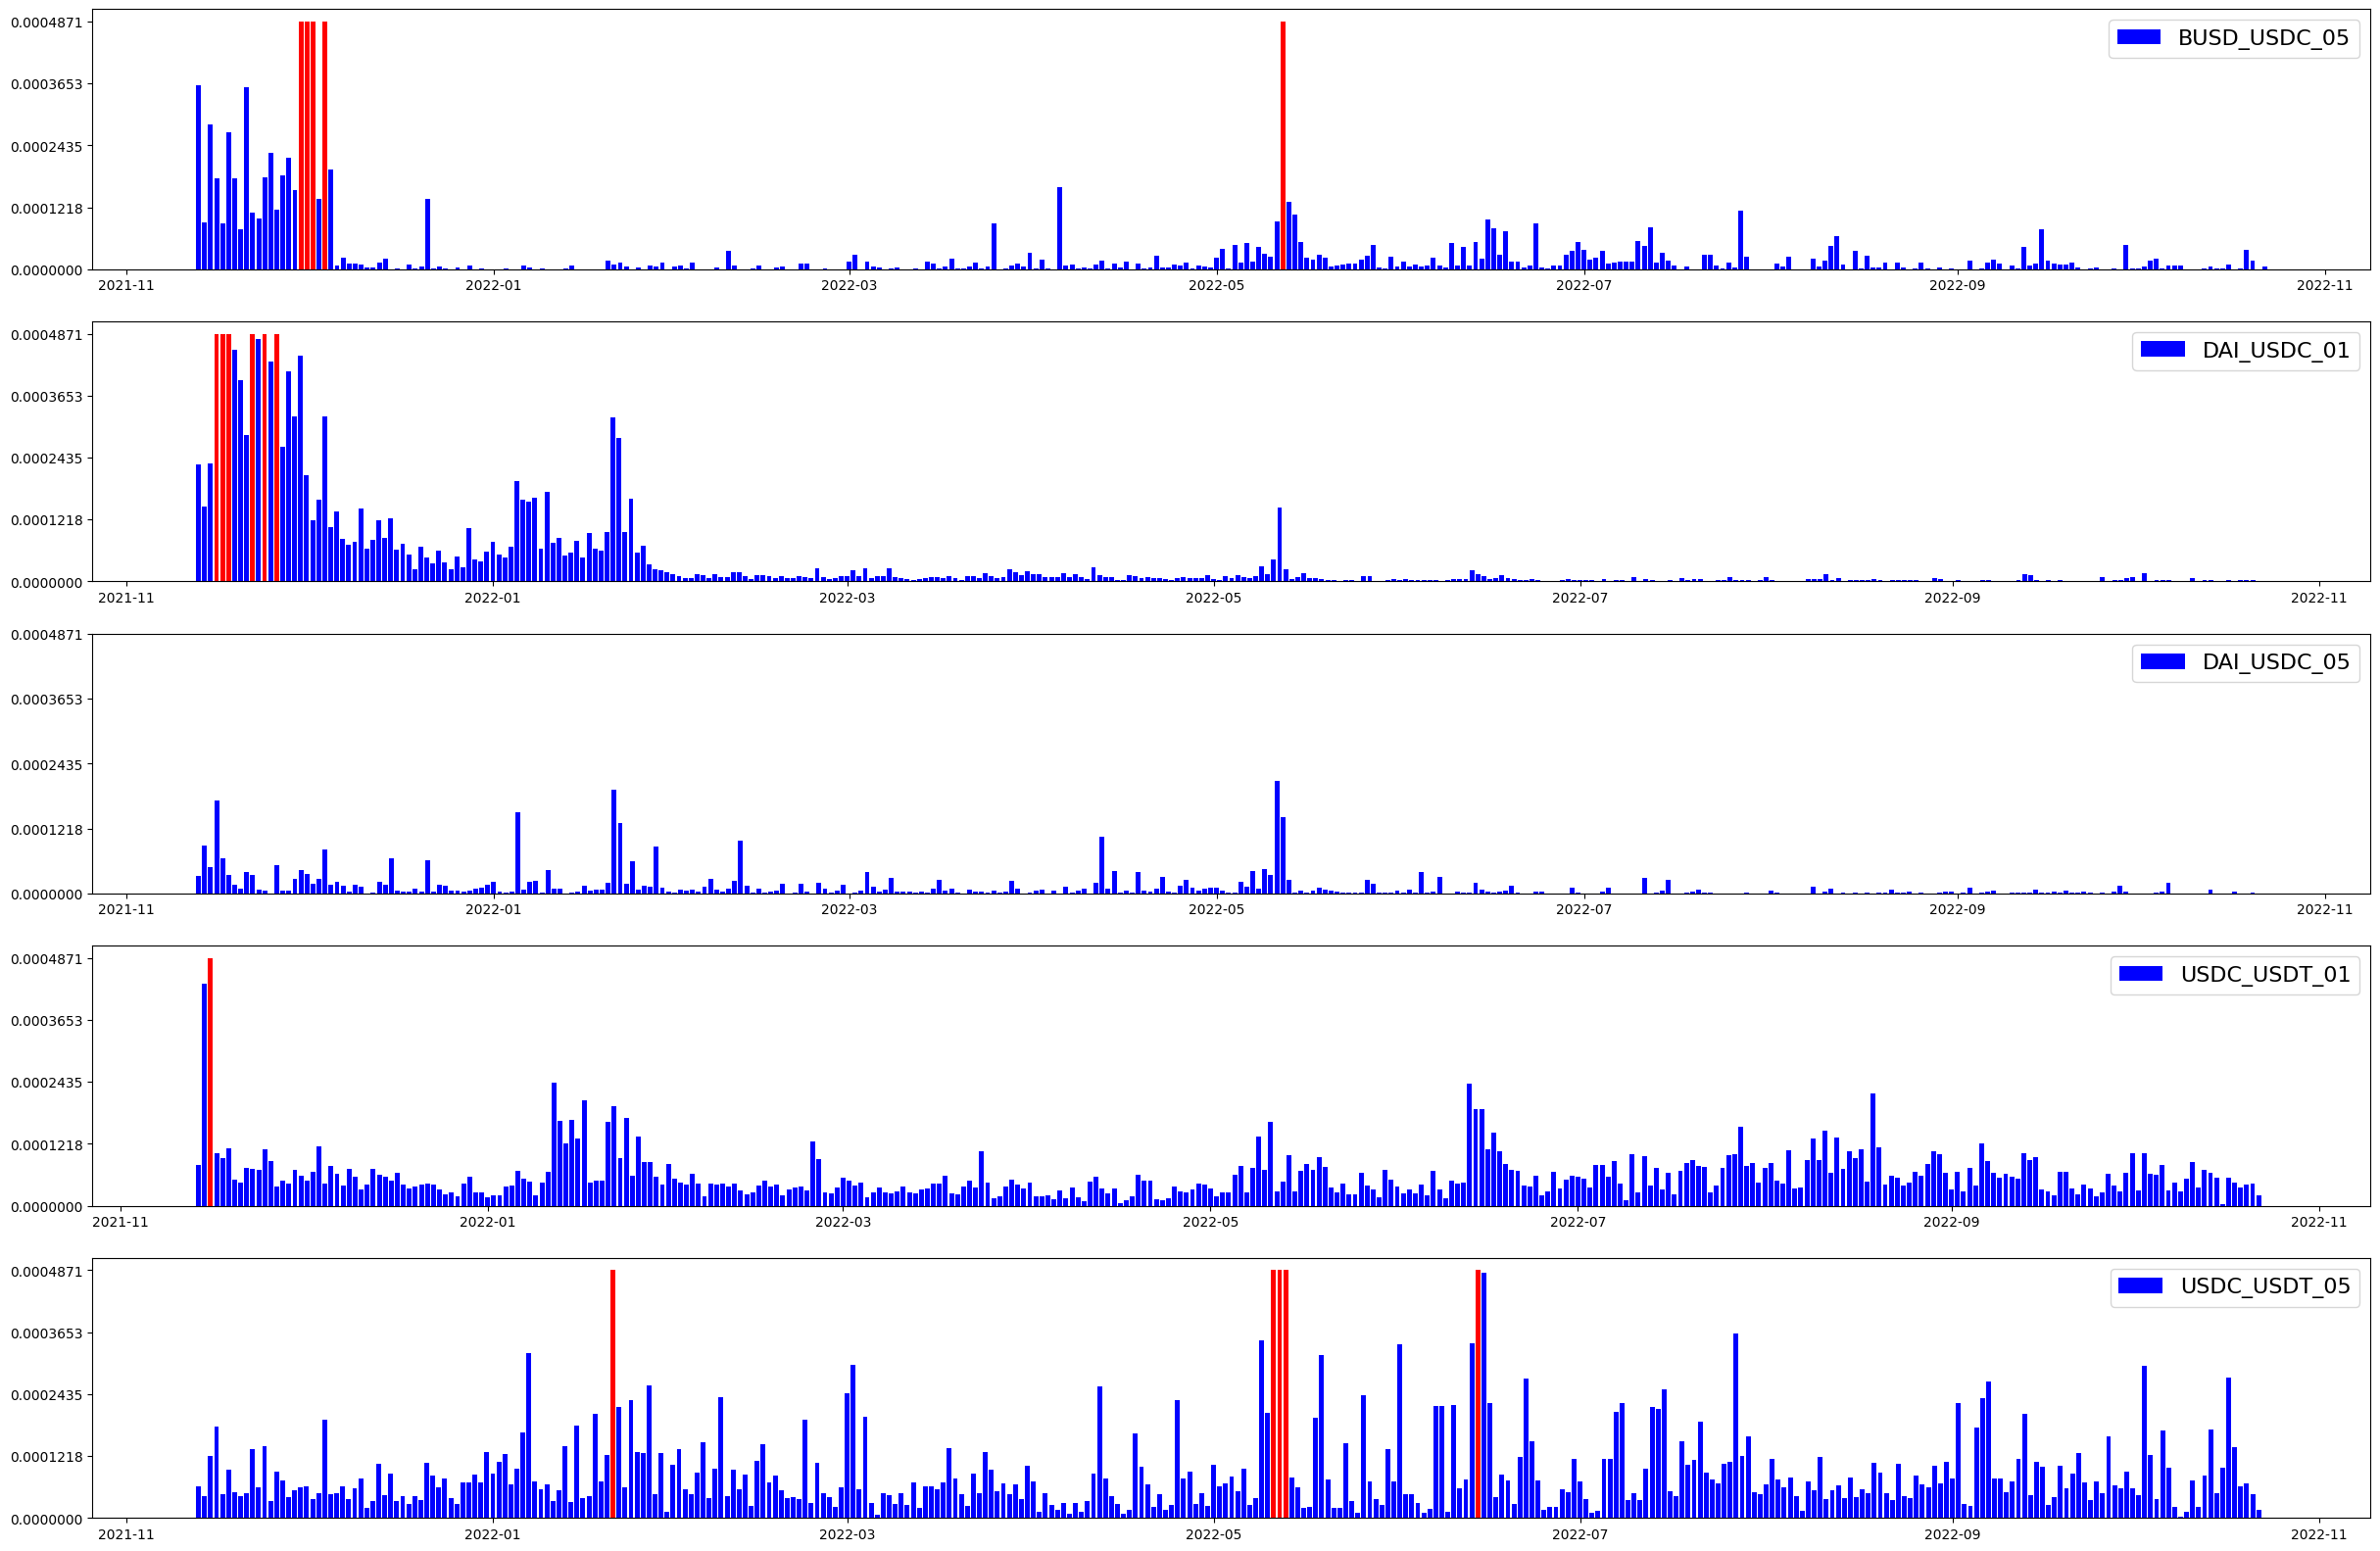

In [16]:
fig,plots=plt.subplots(5,figsize=(30,20))

plot_y=np.linspace(0,cutoff_return,5)

for i,(pool_name,frame) in enumerate(current_env.groupby('pool_name')):
    normal_returns=np.where(frame.returns<cutoff_return,frame.returns,float('nan'))
    outliers=np.where(frame.returns>=cutoff_return,cutoff_return,float('nan'))
    plots[i].bar(frame.date,normal_returns,color='blue',label=pool_name)
    plots[i].bar(frame.date,outliers,color='red')
    plots[i].set_yticks(plot_y)
    plots[i].legend(fontsize=16)